In [693]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.preprocessing import StandardScaler

In [694]:
def load_data(file_path):
    data = pd.read_csv(file_path)
    data['disease'] = data.num.apply(lambda x: min(x,1))
    
    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        
    data = data.drop('num', axis=1)
    data = data.dropna()

    X = data.drop('disease', axis=1)
    y = data['disease']
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    
    return X_scaled_df.values, y.values, X.columns


In [695]:
class kNN(BaseEstimator, ClassifierMixin):
    def __init__(self, k=3, feature_mask=None):
        self.k = k
        self.feature_mask = feature_mask

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        if self.feature_mask is not None:
            X = X[:, self.feature_mask]
        self.X_ = X
        self.y_ = y
        self.classes_ = np.unique(y)
        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        if self.feature_mask is not None:
            X = X[:, self.feature_mask]
        return np.array([self._predict(x) for x in X])

    def _predict(self, x):
        distances = [np.sqrt(np.sum((x - x_train) ** 2)) for x_train in self.X_]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_[i] for i in k_indices]
        return np.argmax(np.bincount(k_nearest_labels))

In [696]:
def cross_validate(X, y, k, feature_mask, n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    f1_scores = []
    precisions = []
    recalls = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model = kNN(k=k, feature_mask=feature_mask)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        f1_scores.append(f1_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        
        # print(f"Fold - Precision: {precisions[-1]:.3f}, Recall: {recalls[-1]:.3f}, F1: {f1_scores[-1]:.3f}")
    
    return f1_scores, precisions, recalls

In [697]:
def feature_importance(X, y, feature_names):
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X, y)
    importances = dt.feature_importances_
    feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    return feature_importance

In [698]:
def elbow(X, y, k_range, feature_mask):
    # Apply the feature mask
    X_masked = X[:, feature_mask]

    X_train, X_test, y_train, y_test = train_test_split(X_masked, y, test_size=0.2, random_state=42)

    scores = []
    for k in k_range:
        knn = kNN(k=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
        scores.append((precision, recall, f1))

    precisions, recalls, f1_scores = zip(*scores)

    plt.figure(figsize=(10, 6))
    plt.plot(k_range, f1_scores)
    plt.xlabel('k')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs k for kNN')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [699]:
# Load the data
X, y, feature_names = load_data('data/cleveland.csv')

importance_results = feature_importance(X, y, feature_names)
print("Feature Importance:")
print(importance_results)

Feature Importance:
thal        0.279725
cp          0.151193
ca          0.108062
thalach     0.083773
chol        0.079608
oldpeak     0.076073
age         0.072169
trestbps    0.050094
slope       0.031960
sex         0.028341
restecg     0.016259
exang       0.012420
fbs         0.010323
dtype: float64


/home/matt/projects/project4-knn-cs5830/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/matt/projects/project4-knn-cs5830/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/matt/projects/project4-knn-cs5830/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

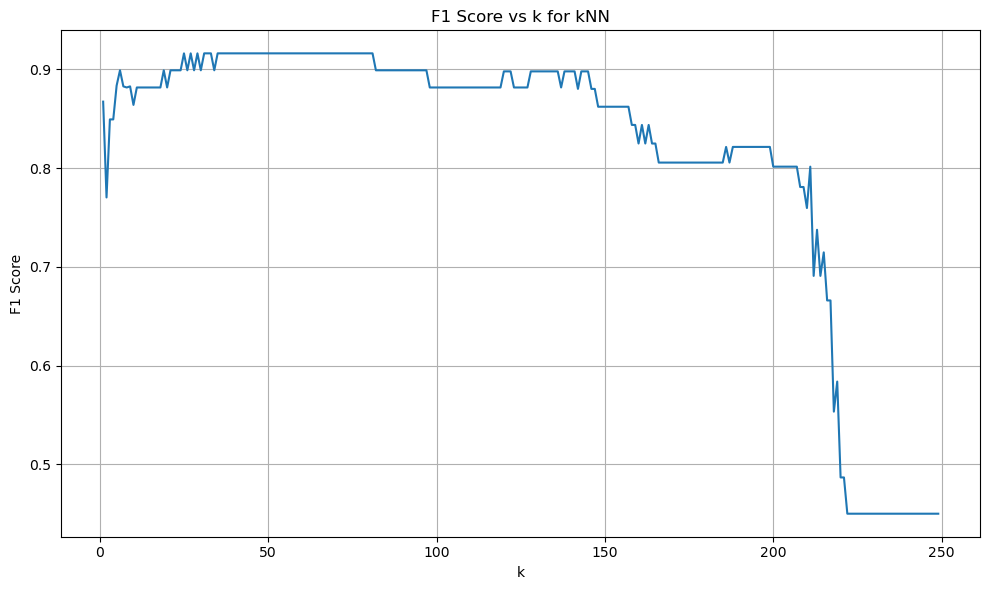

In [700]:
selected_features = ['thal', 'cp', 'ca', 'thalach']

# Create feature mask
feature_mask = np.isin(feature_names, selected_features)

elbow(X, y, range(1, 250), feature_mask)

In [701]:
# Set k based on our elbow plot
k = 150

# Perform cross-validation
f1_scores, precisions, recalls = cross_validate(X, y, k, feature_mask)

# Print results
print(f"Selected features: {selected_features}")
print(f"k value: {k}")
print("\nCross-validation results:")
for i in range(10):
    print(f"Fold {i+1}:")
    print(f"  Precision: {precisions[i]:.3f}")
    print(f"  Recall: {recalls[i]:.3f}")
    print(f"  F1 Score: {f1_scores[i]:.3f}")

print("\nMean scores:")
print(f"Precision: {np.mean(precisions):.3f} (+/- {np.std(precisions):.3f})")
print(f"Recall: {np.mean(recalls):.3f} (+/- {np.std(recalls):.3f})")
print(f"F1 Score: {np.mean(f1_scores):.3f} (+/- {np.std(f1_scores):.3f})")

# Train a model for the test set
final_model = kNN(k=k, feature_mask=feature_mask)
final_model.fit(X, y)

Selected features: ['thal', 'cp', 'ca', 'thalach']
k value: 150

Cross-validation results:
Fold 1:
  Precision: 0.900
  Recall: 0.818
  F1 Score: 0.857
Fold 2:
  Precision: 1.000
  Recall: 0.769
  F1 Score: 0.870
Fold 3:
  Precision: 1.000
  Recall: 0.706
  F1 Score: 0.828
Fold 4:
  Precision: 1.000
  Recall: 0.667
  F1 Score: 0.800
Fold 5:
  Precision: 0.933
  Recall: 0.700
  F1 Score: 0.800
Fold 6:
  Precision: 0.900
  Recall: 0.692
  F1 Score: 0.783
Fold 7:
  Precision: 0.800
  Recall: 0.667
  F1 Score: 0.727
Fold 8:
  Precision: 0.900
  Recall: 0.692
  F1 Score: 0.783
Fold 9:
  Precision: 0.833
  Recall: 0.909
  F1 Score: 0.870
Fold 10:
  Precision: 0.700
  Recall: 0.778
  F1 Score: 0.737

Mean scores:
Precision: 0.897 (+/- 0.092)
Recall: 0.740 (+/- 0.074)
F1 Score: 0.805 (+/- 0.048)


kNN(feature_mask=array([False, False,  True, False, False, False, False,  True, False,
       False, False,  True,  True]),
    k=150)

In [702]:
# Function to predict on challenge dataset
def predict_challenge(challenge_file, model):
    X_challenge, y_challenge, _ = load_data(challenge_file)
    y_pred = model.predict(X_challenge)
    return f1_score(y_challenge, y_pred)

# Predict on the sample test dataset
challenge_f1 = predict_challenge('data/cleveland-test-sample.csv', final_model)
print(f"\nF1 Score on challenge dataset: {challenge_f1:.3f}")


F1 Score on challenge dataset: 0.848
